In [2]:
#!pip install celluloid

In [3]:
# Importing standard python libraries
from math import pi,sqrt
from threading import *

# Import additional python libraries
from matplotlib.animation import FuncAnimation, PillowWriter 
from IPython.display import clear_output, HTML
from celluloid import Camera

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import * # plot_bloch_multivector
from ibm_quantum_widgets import * # CircuitComposer
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector

In [4]:
# Start with an one qubit quantum circuit yielding a nice fractal. Change the circuit as you like.
circuit = QuantumCircuit(1,1)
circuit.h(0)
editor = CircuitComposer(circuit=circuit)
editor

CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001997F7BAD40>)

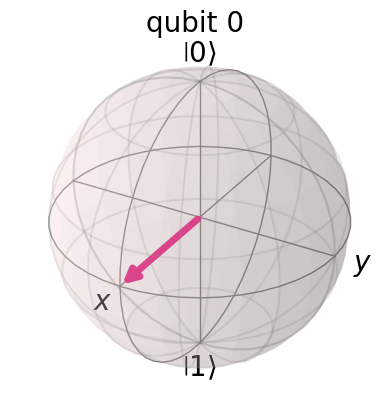

In [5]:
# Generate a Bloch sphere based on the quantum circuit.
qc1 = editor.circuit
plot_bloch_multivector(qc1)

In [6]:
# Run the circuit with the state vector simulator to obtain a noise-free fractal.
backend = Aer.get_backend('statevector_simulator')
out = execute(qc1,backend).result().get_statevector()
#print(out)

# Extract the first element of the state vector as z0 and the second element as z1.
z0 = out.data[0]
z1 = out.data[1]

# Goal: One complex number for the Julia set fractal. 
if z1.real != 0 or z1.imag != 0:
    z = z0/z1
    z = round(z.real, 2) + round(z.imag, 2) * 1j
else:
     z = 0 

In [7]:
# Define the JuliaSet class
class JuliaSet:
    def __init__(self, esc_val: int = 2, height: int = 1000, width: int = 1000, zoom: int = 1, x: int = 0, y: int = 0):
        # Escape value boundary for the magnitude of z
        self.escape_value = esc_val
        
        # To make navigation easier we calculate the ...
        x_width = 1.5
        x_from = x - x_width / zoom
        x_to = x + x_width / zoom

        y_height = 1.5 * height / width
        y_from = y - y_height / zoom
        y_to = y + y_height / zoom

        # Image coordinates used for the initial z value in each Julia set class function
        self.x = np.linspace(x_from, x_to, width).reshape((1, width))
        self.y = np.linspace(y_from, y_to, height).reshape((height, 1))
        self.z = self.x + self.y * 1j

        # Values kept as class variables to reduce compute power
        # -------------------------------------------------------------
        # div_time: To keep track in which iteration the point diverged
        self.div_time = np.zeros(self.z.shape, dtype=int)

        # m: To keep track on which points did not converge so far
        self.m = np.full(self.z.shape, True, dtype=bool)

        # Class values to get the resulting Julia sets
        # -------------------------------------------------------------
        self.res_1cn = None
        
    def set_1cn(self, c: np.complex128, max_iterations: int = 100) -> np.ndarray:
        # Initialize z as x + yi and initialize c to all zero
        z = self.z.copy()
        c = np.full(z.shape, c)

        # Create a copy of the default arrays
        div_time = self.div_time.copy()
        m = self.m.copy()

        # Run the iterative transformation for 1cn
        for i in range(max_iterations):
            z[m] = z[m] ** 2 + c[m]
            m[np.abs(z) > self.escape_value] = False
            div_time[m] = i
        self.res_1cn = div_time

In [8]:
def complexcircuit(tt):
    lqc1 = qc1.copy()
    phl = tt * 2 * pi / frameno
    lqc1.rz(phl,0)
    
    lout = execute(lqc1,backend).result().get_statevector()
    lz0 = lout.data[0]
    lz1 = lout.data[1]

    if lz1.real != 0 or lz1.imag != 0:
            lz = lz0/lz1
            lz = round(lz.real, 2) + round(lz.imag, 2) * 1j
    else:
        lz = 0
            
    return lz, lqc1

In [9]:
# Define the animations class
class QuantumFractalImages:
    def __init__(self, i: int, cno: np.complex128, ccircuit: QuantumCircuit):
        # Firstly, calculate the three types of Julia Sets
        # Create the threads based on each function the the Julia Set Class
        self.Julia = JuliaSet()
        threads = [
            Thread(target=self.Julia.set_1cn, kwargs={"c": cno})
        ]

        # Start the threads
        for thread in threads:
            thread.start()

        # Wait for all threads to complete:
        for thread in threads:
            thread.join()
        
        # Define the results from the three calculations
        self.i = i
        self.res_1cn = self.Julia.res_1cn
    
    def qfanimations(self):      
        # Secondly (a), generate the images based on the Julia set results
        plot_bloch_multivector(ccircuit, filename='H.png')
        ax[0].imshow(mpimg.imread('H.png'))
        ax[0].axis('off')
        ax[1].imshow(self.res_1cn, cmap='magma')
        ax[1].axis('off')
        camera.snap()
        plt.close()
        
    
    def qfimages(self):
        # Secondly (b), generate the images based on the Julia set results
        clear_output(wait=True) # remove if you want to see all images in a loop
        fig, ax = plt.subplots(1,2, figsize=(20,20)) 

        print("Loop i =",i, " One complex no =", round(cno.real,2)+round(cno.imag,2)*1j)
        plot_bloch_multivector(ccircuit, filename='H.png')
        ax[0].imshow(mpimg.imread('H.png'))
        ax[0].axis('off')
        ax[1].imshow(self.res_1cn, cmap='magma')
        ax[1].axis('off')
        plt.show()
        plt.close()

Loop i = 4  One complex no = (0.91-0.41j)


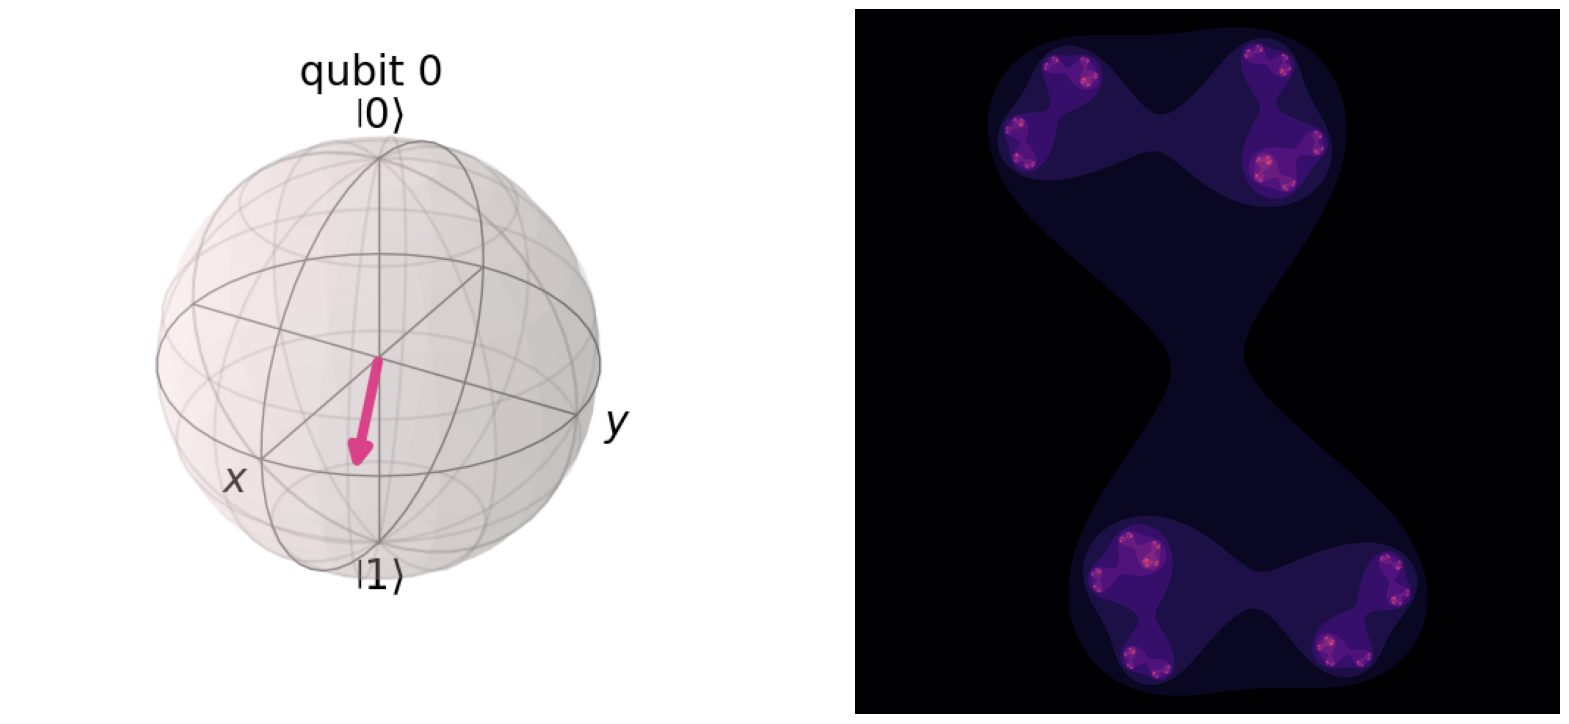

KeyboardInterrupt: 

In [14]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
camera = Camera(fig)

frameps = 5 #Used below to calculate interval between images
frameno = 60
for i in range(frameno):
    # Firstly, get the complex numbers from the complex circuit
    ccc = complexcircuit(i)
    
    # Secondly, for the sake of transparency, the elements from the list are defined as seperate variables
    cno = ccc[0]
    ccircuit = ccc[1]

    # Thirdly, run the animation and image creation
    QFI = QuantumFractalImages(i=i, cno = cno, ccircuit = ccircuit)
    QFI.qfanimations()
    QFI.qfimages()

interval = 1000/frameps
anim = camera.animate(blit=True, interval=interval)

clear_output()
HTML(anim.to_html5_video())